In [1]:
# Imports
import os
import numpy as np
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Activation, Flatten, MaxPooling2D, SeparableConv2D, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import seaborn as sns

# import plot model
from tensorflow.keras.utils import plot_model

img_rows, img_cols = 64, 64
train_data_dir = './dataset_new/train'
validation_data_dir = './dataset_new/val'


In [2]:
IMG_SHAPE = img_cols, img_rows, 3
classes = 3
batch_size = 64

In [3]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

datagen = ImageDataGenerator(rescale=1./255)

#automatically retrive images and their classes for training and validation
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')


Found 4810 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


In [4]:
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples

print('num_train_samples: ' + str(num_train_samples))
print('num_validation_samples: ' + str(num_validation_samples))

num_train_samples: 4810
num_validation_samples: 1200


In [5]:
def entry_flow(inputs):

    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728]:

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(
            previous_block_activation)

        x = tensorflow.keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x


In [6]:
def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        # x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        # x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        # x = BatchNormalization()(x)

        x = tensorflow.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [7]:
def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    #x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x) 
    #x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = tensorflow.keras.layers.Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    #x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    #x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)

    return x

In [8]:
inputs = Input(shape=(img_rows, img_cols, 3))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = Model(inputs, outputs)

2021-10-20 21:48:12.612875: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-20 21:48:13.140357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2549 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

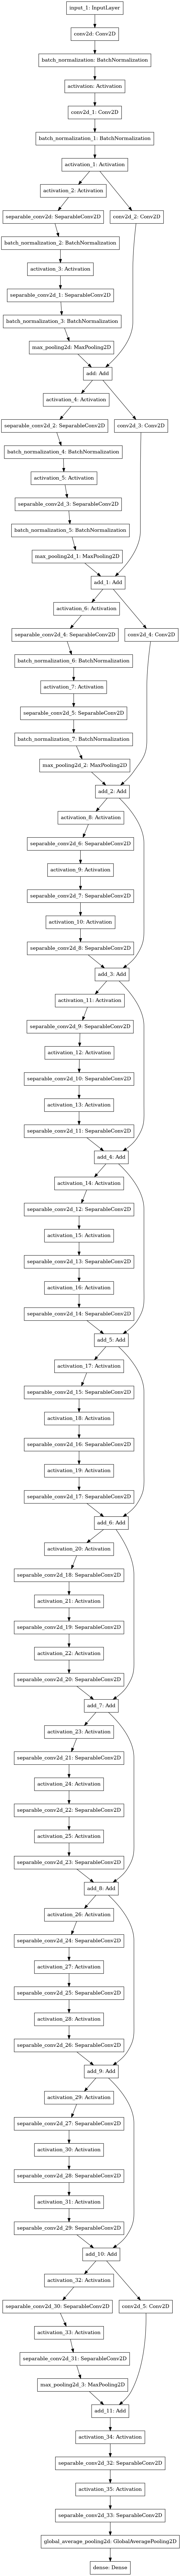

In [9]:
xception.summary()
# plot the model
plot_model(xception, to_file='./graph/xception.png')

In [10]:
opt = tensorflow.keras.optimizers.Adam()
xception.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [11]:
history_1= xception.fit_generator(train_generator,
                    steps_per_epoch=num_train_samples // batch_size,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=num_validation_samples // batch_size)

/home/nsssayom/.local/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-20 21:48:14.440849: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-10-20 21:48:18.319717: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-10-20 21:48:19.515691: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-20 21:48:19.539180: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-20 21:48:19.555225: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

75/75 [==============================] - 24s 241ms/step - loss: 0.4193 - accuracy: 0.7944 - val_loss: 1.3952 - val_accuracy: 0.2083
Epoch 2/30
75/75 [==============================] - 17s 220ms/step - loss: 0.1945 - accuracy: 0.9241 - val_loss: 2.2565 - val_accuracy: 0.2083
Epoch 3/30
75/75 [==============================] - 16s 218ms/step - loss: 0.1605 - accuracy: 0.9383 - val_loss: 3.0574 - val_accuracy: 0.2083
Epoch 4/30
75/75 [==============================] - 16s 219ms/step - loss: 0.1527 - accuracy: 0.9452 - val_loss: 3.4545 - val_accuracy: 0.2083
Epoch 5/30
75/75 [==============================] - 17s 223ms/step - loss: 0.1203 - accuracy: 0.9530 - val_loss: 5.6017 - val_accuracy: 0.2083
Epoch 6/30
75/75 [==============================] - 16s 219ms/step - loss: 0.1131 - accuracy: 0.9585 - val_loss: 1.9416 - val_accuracy: 0.4948
Epoch 7/30
75/75 [==============================] - 16s 218ms/step - loss: 0.1076 - accuracy: 0.9585 - val_loss: 0.5706 - val_accuracy: 0.8689
Epoch 8/30

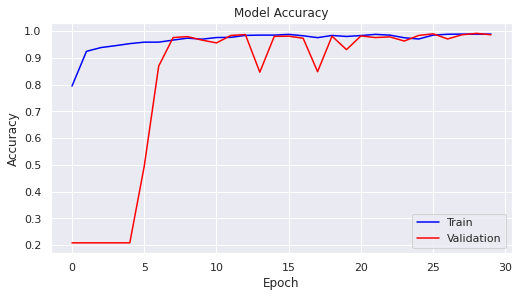

In [17]:
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['accuracy'], color="blue")
plt.plot(history_1.history['val_accuracy'] , color="red")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('./graph/TwoClass_accuracy_raw_1.svg')


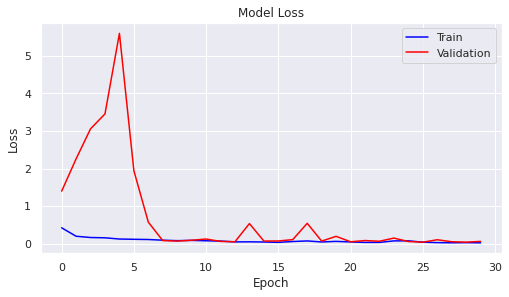

In [18]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['loss'], color="blue")
plt.plot(history_1.history['val_loss'], color="red")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('./graph/TwoClass_loss_raw_1.svg')
#plt.savefig('G:/Nazia/BanglaLekha/Comp-graph/Com_loss18.png')

In [19]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
batch_size=64

In [24]:
Y_pred = xception.predict_generator(validation_generator, num_validation_samples// batch_size+1)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true= validation_generator.classes
target_names = ['Horizontal-Cracked', 'Non-Cracked', 'Vertical-Cracked']
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))


/home/nsssayom/.local/lib/python3.9/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(1200, 3)
                    precision    recall  f1-score   support

Horizontal-Cracked      0.985     0.983     0.984       480
       Non-Cracked      1.000     0.996     0.998       240
  Vertical-Cracked      0.981     0.985     0.983       480

          accuracy                          0.987      1200
         macro avg      0.989     0.988     0.989      1200
      weighted avg      0.987     0.987     0.987      1200



In [25]:
cm = confusion_matrix(y_true, y_pred)

In [26]:
classes=3

In [27]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]), ):
        plt.text(j, i, cm[i, j, ],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

In [36]:
import imp
imp.reload(sns)

<module 'seaborn' from '/home/nsssayom/.local/lib/python3.9/site-packages/seaborn/__init__.py'>

In [37]:
sns.reset_defaults()
# sns.set(font_scale=1.4)

Confusion matrix, without normalization
[[472   0   8]
 [  0 239   1]
 [  7   0 473]]


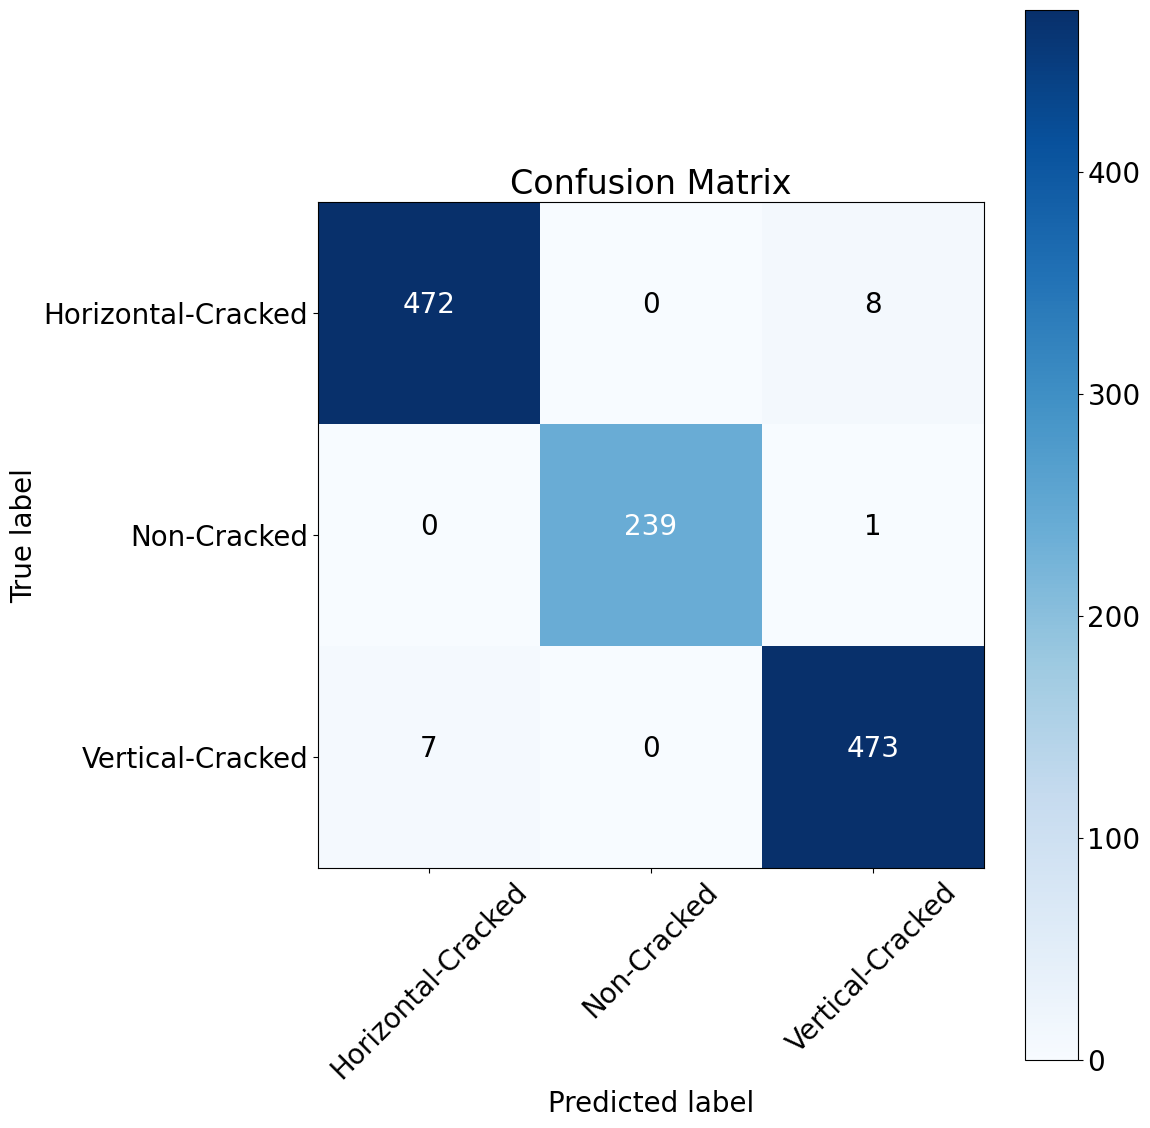

In [39]:
plt.rcParams.update({'font.size': 20})
cm_plot_labels = ['Horizontal-Cracked', 'Non-Cracked', 'Vertical-Cracked']
#sns.set_theme()
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig('./graph/TwoClass_conf_Raw_1.svg')
#plt.savefig('G:/Nazia/BanglaLekha/Comp-graph/cf_val_git_05.png')
